# WRUV Broadcasting Dataset Project
Authors: Sydney White and Zachary Hayes

In [15]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import time
from sklearn.model_selection import train_test_split

## Data Collection, Cleaning, and Feature Engineering
#### Initial Collection and Cleaning


In [16]:
# Collect data CSVs into a single dataframe
dfs = []
directory = "dataset" 
for file in os.listdir(directory):
    df = pd.read_csv(f'{directory}/{file}')
    dfs.append(pd.read_csv(f'{directory}/{file}'))
df = pd.concat(dfs, axis=0)
df.sort_values("Date-time", inplace=True, ignore_index=True)
# Drop columns that we already know we don't need
df.drop(["Playlist Category", "DJ Email", "Date-time", "Composer"], axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df

PermissionError: [Errno 13] Permission denied: 'dataset/.ipynb_checkpoints'

In [3]:
# Count null values
df.isna().sum()

NameError: name 'df' is not defined

In [3]:
# Clean the null values from the boolean columns New and Local
df["New"] = df["New"].map({"N": 1, np.nan: 0})
df["Local"] = df["Local"].map({"L": 1, np.nan: 0})

# Since there are only 56 instances where artist, song, or release are null,
# we feel comfortable dropping those instances
df = df.dropna(subset=["Artist", "Song", "Release"])

# Count null values again
df.isna().sum()


Playlist Title           0
Playlist Duration        0
DJ ID                    0
DJ Name                  0
Date                     0
Time                     0
Artist                   0
Song                     0
Release                  0
New                      0
Local                    0
Genre                97305
Label                 1095
UPC                  28182
dtype: int64

In [ ]:
# A simplfied billboard scraping function
def artist_billboard(artist_name):
    # convert artist name to - if spaces
    artist_name = artist_name.lower()
    artist_name = artist_name.replace(' ', '-')
    # if the name is in the saved dictionary (also saves time) 
    if artist_name in ARTIST_BB.keys():
        return ARTIST_BB[artist_name]
    else:
        base = 'https://www.billboard.com/artist/'
        url = base + artist_name
        page = requests.get(url)
        # if the page is not found, they are not a billboard artist 
        if page.reason == "Not Found":
            ARTIST_BB[artist_name] = 0
            return 0
        else:
            return 1 

# to apply: df['artistBB'] = df['Artist'].apply(artist_billboard)

#### Smaller Dataset for Policy Violation Regression 

In [96]:
# Define smaller data set for linear regression (for now)
slices = []
# slices are of size 100 due to Spotify constraints, currently 0 - 110 (ever growing) 
for i in range(162):
    slices.append(pd.read_csv(f'slices/slice{i}.csv'))
small = pd.concat(slices, axis=0)
small["Date"] = pd.to_datetime(small["Date"])
small["Day"] = pd.to_datetime(small["Date"]).dt.day_name()
small.fillna(0, inplace = True)
small

,Unnamed: 0.1,Unnamed: 0,Playlist Title,DJ ID,DJ Name,Date,Time,Artist,Song,Release,...,loudness,mode,speechiness,acousticness,instruemtnalness,liveness,valence,tempo,duration_ms,Day
0,0,32428,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:00:43 AM,Darian Stavans,Ballad,Jazzy´Blue,...,0.000,0.0,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,0.0,Monday
1,1,32429,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:03:25 AM,Mack Fields,I Like to Yodel,"Cults Hits Novelty Classics, Vol. 1",...,0.000,0.0,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,0.0,Monday
2,2,32430,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:05:48 AM,Real Estate,Water Underground,Water Underground,...,-7.245,1.0,0.0314,0.0232,0.05420,0.1330,0.9190,111.907,206547.0,Monday
3,3,32431,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:09:14 AM,My Morning Jacket,Feelin Sorry,Feelin Sorry,...,0.000,0.0,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,0.0,Monday
4,4,32432,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:12:02 AM,Joni Mitchell,A Case of You (feat. Marcus Mumford),A Case of You (feat. Marcus Mumford) (Live at ...,...,0.000,0.0,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,0.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16195,48625,"WRUV 2/18/24, 3:03 PM",64581,Program Director,2024-02-18,3:58:51 PM,Greg Freeman,Come and Change My Body,Come and Change My Body,...,-7.591,0.0,0.1060,0.0343,0.00286,0.5840,0.3690,172.235,252900.0,Sunday
96,16196,48626,Everyday Sunshine,66634,The Purple Shaman,2024-02-18,4:00:45 PM,CAN,Sing Swan Song - 2004 Remastered Version,Ege Bamyasi (Remastered Version),...,-12.210,0.0,0.0942,0.2050,0.55300,0.4730,0.3890,154.132,289333.0,Sunday
97,16197,48627,Everyday Sunshine,66634,The Purple Shaman,2024-02-18,4:05:25 PM,Astral Underground,Sunsets are Sacred,Sunsets are Sacred,...,-14.357,1.0,0.0430,0.5620,0.85300,0.1790,0.0405,81.338,516877.0,Sunday
98,16198,48628,Everyday Sunshine,66634,The Purple Shaman,2024-02-18,4:13:57 PM,Animal Collective,Magicians From Baltimore,Isn’t It Now?,...,-6.192,1.0,0.0620,0.5690,0.02340,0.0779,0.2160,152.354,567428.0,Sunday


#### Additional Collection: Filling Missing Genres and Spotify Audio Features

In [114]:
# global variable for valid genres in spinitron 
GENRES = small['Genre'].unique().tolist()
for g in range(len(GENRES)):
    GENRES[g] = (str(GENRES[g])).lower()
    
# function to interface with Spotify Web API app (created with id and secret below) STILL WIP!
def spotify_connect():
    # technically insecure to have client secret displayed like this (environment variable)
    CLIENT_ID = '344d3b062e344710a5bdb8427358a31d'
    CLIENT_SECRET = '9f886dde51184f989b1aff4f5ffb21f8'
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    auth_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        requests_session=True)

    sp = spotipy.Spotify(auth_manager=auth_manager)
    # this is our connection which we will need for any future query 
    return sp
    
# just making this global for effeciency (no need to reaccess every time) 
sp = spotify_connect()

def get_genre_by_artist(artist_name):
    # spotify queries are all based on Spotify URI IDs and usually return in JSON
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=10)
    except TypeError:
        print(artist_name + "unable to search")
        return 'NA'
    # make sure that the result is for the artist we want
    try: 
        result_name = results['artists']['items'][0]['name']
    except IndexError:
        result_name = ''
        return 'NA'
    i = 0
    while (result_name != artist_name) & (i < 10) & (i < len(results)):
        result_name = results['artists']['items'][i]['name']
        i += 1
    if (result_name == artist_name):
        genres = results['artists']['items'][i]['genres'] # for top result (in this case accurate, but probably not always)
        id = results['artists']['items'][i]['id']
        for genre in genres:
            if genre in GENRES:
                return genre 
    return 'NA'

# to use: apply in sections of 100 from the original dataframe with 
small.loc[small["Genre"] == 0, "Genre"] = small.loc[small["Genre"].isna()].apply(get_genre_by_artist)


In [115]:
print(df["Genre"].isna().sum())
print(df["Genre"].describe())

NameError: name 'df' is not defined

#### Data Wrangling and Visualization

<BarContainer object of 20 artists>

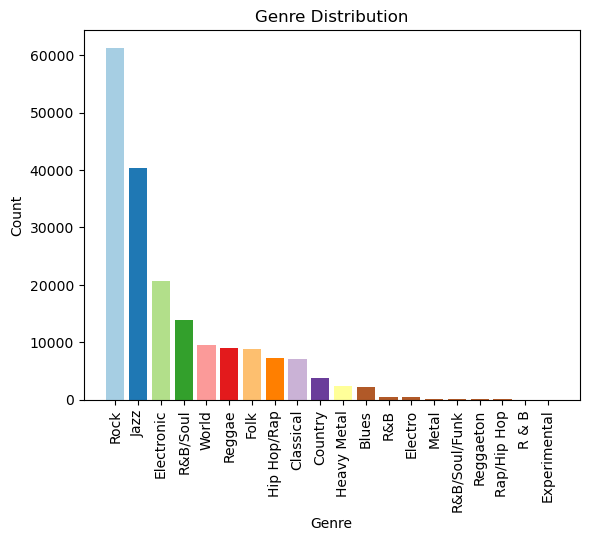

In [8]:
# Visualize genre distribution
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))


In [116]:
# Combine genres in the dataframe
# (Replace with higher count genre)
df = df.replace(
    {
        "R&B": "R&B/Soul",
        "Electro": "Electronic",
        "Metal": "Heavy Metal",
        "R&B/Soul/Funk": "R&B/Soul",
        "Reggaeton": "Reggae",
        "Rap/Hip Hop": "Hip Hop/Rap",
        "R & B": "R&B/Soul"
    }
)

small = small.replace(
    {
        "R&B": "R&B/Soul",
        "Electro": "Electronic",
        "Metal": "Heavy Metal",
        "R&B/Soul/Funk": "R&B/Soul",
        "Reggaeton": "Reggae",
        "Rap/Hip Hop": "Hip Hop/Rap",
        "R & B": "R&B/Soul"
    }
)

# Visualize genre distribution, again
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))

Genre
Rock            2989
Jazz            2108
Electronic      1175
R&B/Soul         788
Folk             622
Reggae           400
World            387
Classical        251
Hip Hop/Rap      232
Country          219
Heavy Metal       94
Blues             75
Experimental       1
Name: count, dtype: int64


'\n# Visualize genre distribution, again\ngenre_counts = df["Genre"].value_counts()\nplt.title("Genre Distribution")\nplt.xlabel("Genre")\nplt.ylabel("Count")\nplt.xticks(rotation=90)\nplt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))\n'

<Axes: >

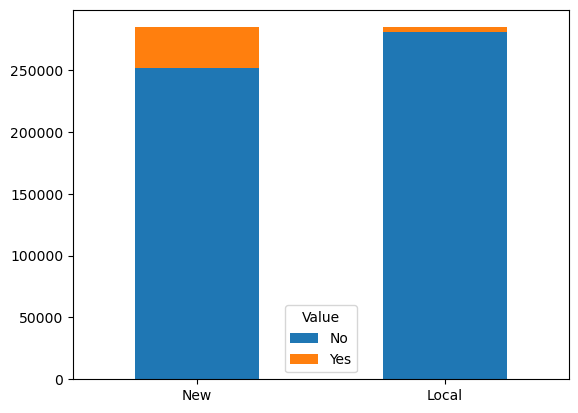

In [9]:
# Visualize local and new distributions
total_spins = df.shape[0]
num_new = df["New"].sum()
num_local = df["Local"].sum()
new_and_local = pd.DataFrame({"New": [total_spins - num_new, num_new],
                              "Local": [total_spins - num_local, num_local],
                              "Value": ["No", "Yes"]}).set_index("Value")
new_and_local.T.plot.bar(stacked=True, rot=0)
    

In [4]:
# Temporary add (for work below), until the feature is properly created via scraping
df["Top100"] = np.random.randint(0, 1, df.shape[0])

# see artist_billboard function above! 

C:\Users\Zachary\AppData\Local\Temp\ipykernel_6948\639479631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Top100"] = np.random.randint(0, 1, df.shape[0])


In [97]:
def spins_to_dj(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in dj format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    # Engineered Features: avg time of day (start time), avg duration, average # spins
    eng_df = spin_df[["DJ Name", "Playlist Title", "Playlist Duration", "Date", "Time"]]

    pattern = "%I:%M:%S %p"
    def to_min(x):
        time_extracted = datetime.strptime(x, pattern)
        return time_extracted.hour*60 + time_extracted.minute
    eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))
    start_times_df = eng_df.groupby(["DJ Name", "Date"]).min().reset_index()
    dj_df["Avg_Start"] = start_times_df[["DJ Name", "Time"]].groupby("DJ Name").mean().reset_index()["Time"]

    duration_df = eng_df[["DJ Name", "Playlist Duration"]]
    dj_df["Avg_Duration"] = duration_df.groupby("DJ Name").mean().reset_index()["Playlist Duration"]

    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    avg_spin_df = one_day_spin_count_df[["DJ Name", "Playlist Title"]].groupby("DJ Name").mean().reset_index()
    dj_df["Avg_Spins"] = avg_spin_df["Playlist Title"]

    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index="DJ Name", columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on="DJ Name", how='inner')

    # Count new music policy violations
    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(one_day_new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')

    # Count popular artist policy violations
    dj_df["top_violations"] = spin_df[["DJ Name", "Top100"]].groupby(["DJ Name"]).sum().reset_index()["Top100"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["top_violations"]
    dj_df = dj_df.drop(columns=["new_violations", "top_violations"])

    return dj_df

djs_df = spins_to_dj(spin_df=df)
djs_df

NameError: name 'df' is not defined

In [130]:
def spins_to_dj_small(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in dj format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    # Engineered Features: avg time of day (start time), avg duration, average # spins
    eng_df = spin_df[["DJ Name", "Playlist Title", "Date", "Time"]]

    pattern = "%I:%M:%S %p"
    def to_min(x):
        time_extracted = datetime.strptime(x, pattern)
        return time_extracted.hour*60 + time_extracted.minute
    eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))
    start_times_df = eng_df.groupby(["DJ Name", "Date"]).min().reset_index()
    dj_df["Avg_Start"] = start_times_df[["DJ Name", "Time"]].groupby("DJ Name").mean().reset_index()["Time"]

    #duration_df = eng_df[["DJ Name", "Playlist Duration"]]
    #dj_df["Avg_Duration"] = duration_df.groupby("DJ Name").mean().reset_index()["Playlist Duration"]

    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    avg_spin_df = one_day_spin_count_df[["DJ Name", "Playlist Title"]].groupby("DJ Name").mean().reset_index()
    dj_df["Avg_Spins"] = avg_spin_df["Playlist Title"]

    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index="DJ Name", columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on="DJ Name", how='inner')

    # Count new music policy violations
    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(one_day_new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')
    
     # audio features
    audio_df = spin_df[["DJ Name", "Date", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instruemtnalness", "liveness", "valence", "tempo", "duration_ms"]].groupby(["DJ Name"]).mean()
    dj_df = pd.merge(dj_df, audio_df, on=["DJ Name"], how='outer')

    #3dj_df["new_percent"] = dj_df["New"] / dj_df["Total_Spins"]
    #dj_df["new_violations"] = (dj_df["new_percent"] < 0.25).astype(int)

    # Count popular artist policy violations
    dj_df["artist_bb"] = spin_df[["DJ Name", "artistBB"]].groupby(["DJ Name"]).sum().reset_index()["artistBB"]
    dj_df["artist_violations"] = dj_df["artist_bb"] / dj_df["Total_Spins"]
    dj_df["popular_violations"] = (dj_df["artist_violations"] > 0.2).astype(int)
    

    dj_df["song_violations"] = spin_df[["DJ Name", "songBB"]].groupby(["DJ Name"]).sum().reset_index()["songBB"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["popular_violations"] + dj_df["song_violations"]


    return dj_df

dj_df_small = spins_to_dj_small(small)
dj_df_small

C:\Users\16107\AppData\Local\Temp\ipykernel_12616\3873361213.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))


Index(['DJ Name', 'Total_Spins', 'Avg_Start', 'Avg_Spins', 'Blues',
       'Classical', 'Country', 'Electronic', 'Experimental', 'Folk',
       'Heavy Metal', 'Hip Hop/Rap', 'Jazz', 'R&B/Soul', 'Reggae', 'Rock',
       'World', 'new_violations', 'Date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instruemtnalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'artist_bb',
       'artist_violations', 'popular_violations', 'song_violations',
       'Violations'],
      dtype='object')

,DJ Name,Total_Spins,Avg_Start,Avg_Spins,Blues,Classical,Country,Electronic,Experimental,Folk,...,instruemtnalness,liveness,valence,tempo,duration_ms,artist_bb,artist_violations,popular_violations,song_violations,Violations
60,JAH RED,519,876.125000,32.437500,0.0,0.0,0.0,2.0,0.0,0.0,...,0.017692,0.038336,0.165459,27.822148,47902.036609,47,0.090559,0,0,16
71,Program Director,4908,51.918367,100.163265,16.0,5.0,57.0,378.0,0.0,174.0,...,0.103466,0.072248,0.184139,42.220659,86253.218011,259,0.052771,0,0,49


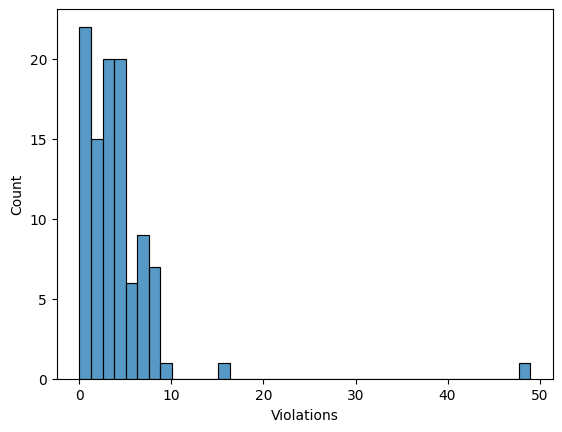

In [143]:
sns.histplot(dj_df_small["Violations"])
dj_df_small["Violations"] = dj_df_small["Violations"].astype(int)
dj_df_small.loc[dj_df_small["Violations"] >= 12]

In [117]:
def spins_to_shows(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in spin format
    """
    
    dj_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Date", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    dj_df = pd.merge(one_day_new_df, dj_df, on=["DJ Name", "Date"], how='outer')

    # time of day 
    dj_df["Time"] = spin_df[["Time", "DJ Name", "Date"]].groupby(["DJ Name", "Date"]).min().reset_index()["Time"]
    
    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Date", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title", "Date"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index=["DJ Name", "Date"], columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on=["DJ Name", "Date"], how='outer')

    # audio features
    audio_df = spin_df[["DJ Name", "Date", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instruemtnalness", "liveness", "valence", "tempo", "duration_ms"]].groupby(["DJ Name", "Date"]).mean()
    dj_df = pd.merge(dj_df, audio_df, on=["DJ Name", "Date"], how='outer')
    
    dj_df["new_percent"] = dj_df["New"] / dj_df["Total_Spins"]
    dj_df["new_violations"] = (dj_df["new_percent"] < 0.25).astype(int)

    # Count popular artist policy violations
    dj_df["artist_bb"] = spin_df[["DJ Name", "artistBB"]].groupby(["DJ Name"]).sum().reset_index()["artistBB"]
    dj_df["artist_violations"] = dj_df["artist_bb"] / dj_df["Total_Spins"]
    dj_df["popular_violations"] = (dj_df["artist_violations"] > 0.2).astype(int)
    

    dj_df["song_violations"] = spin_df[["DJ Name", "songBB"]].groupby(["DJ Name"]).sum().reset_index()["songBB"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["popular_violations"] + dj_df["song_violations"]

    
    return dj_df


small_djs = spins_to_shows(small)
small_djs.fillna(0, inplace= True)
small_djs

,DJ Name,Date,New,Total_Spins,Time,Blues,Classical,Country,Electronic,Experimental,...,valence,tempo,duration_ms,new_percent,new_violations,artist_bb,artist_violations,popular_violations,song_violations,Violations
0,Adam Higgins,2024-01-05,7,22,12:06:25 AM,0.0,5.0,0.0,14.0,0.0,...,0.055318,14.240864,45414.454545,0.318182,0,8.0,0.363636,1,0.0,1.0
1,Adam Higgins,2024-01-12,8,24,12:02:22 AM,0.0,8.0,0.0,8.0,1.0,...,0.048150,15.140833,62700.000000,0.333333,0,2.0,0.083333,0,0.0,0.0
2,Adam Higgins,2024-01-19,8,25,12:03:00 AM,0.0,8.0,0.0,17.0,0.0,...,0.001200,2.473560,5027.680000,0.320000,0,20.0,0.800000,1,0.0,1.0
3,Adam Higgins,2024-01-26,8,30,12:07:00 AM,0.0,8.0,0.0,18.0,0.0,...,0.037863,12.686500,53041.366667,0.266667,0,2.0,0.066667,0,0.0,0.0
4,Adam Higgins,2024-02-02,8,24,12:07:00 AM,0.0,8.0,0.0,3.0,0.0,...,0.097946,24.457917,68776.208333,0.333333,0,24.0,1.000000,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,otis cleveland,2024-01-16,0,21,10:16:13 PM,0.0,2.0,1.0,0.0,0.0,...,0.099571,33.781762,55820.952381,0.000000,1,0.0,0.000000,0,0.0,0.0
554,otis cleveland,2024-01-23,0,20,8:00:21 PM,0.0,2.0,0.0,1.0,0.0,...,0.059550,21.756650,52204.000000,0.000000,1,0.0,0.000000,0,0.0,0.0
555,otis cleveland,2024-01-30,0,40,8:00:33 PM,1.0,0.0,1.0,3.0,0.0,...,0.183845,42.370225,57160.150000,0.000000,1,0.0,0.000000,0,0.0,0.0
556,otis cleveland,2024-02-06,0,18,8:01:38 PM,0.0,0.0,1.0,0.0,0.0,...,0.149944,29.168389,55307.111111,0.000000,1,0.0,0.000000,0,0.0,0.0


<Axes: xlabel='Violations', ylabel='Count'>

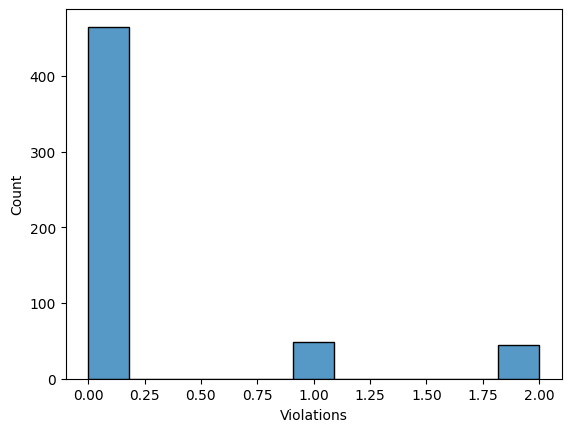

In [118]:
sns.histplot(small_djs["Violations"])

## Data Modeling

### Policy Violation Linear Regression

In [99]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score 

#### Splitting and Preparing Data

In [102]:
small_djs.drop(0)
small_djs.columns = small_djs.columns.astype(str)

train, test = train_test_split(small_djs, test_size = 0.2, train_size = 0.8)
small_djs_X = small_djs.drop(["DJ Name", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations"], axis=1)
small_djs_Y = small_djs["Violations"]
small_djs_X_train = train.drop(["DJ Name", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations"], axis=1)
small_djs_X_test = test.drop(["DJ Name", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations"], axis=1)
small_djs_Y_train = train["Violations"]
small_djs_Y_test = test["Violations"]

#### Creating Model

In [103]:
regr = linear_model.LinearRegression()
regr.fit(small_djs_X_train, small_djs_Y_train)
small_djs_Y_pred = regr.predict(small_djs_X_test)
print("Coefficients: \n", regr.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, small_djs_Y_pred)}')
print(f'{regr.score(small_djs_X_test, small_djs_Y_test)}')
#print(f'R squared: {r2_score(small_djs_Y_test, small_djs_Y_train)}')

ValueError: could not convert string to float: '10:00:31 AM'

Text(0.5, 1.0, '')

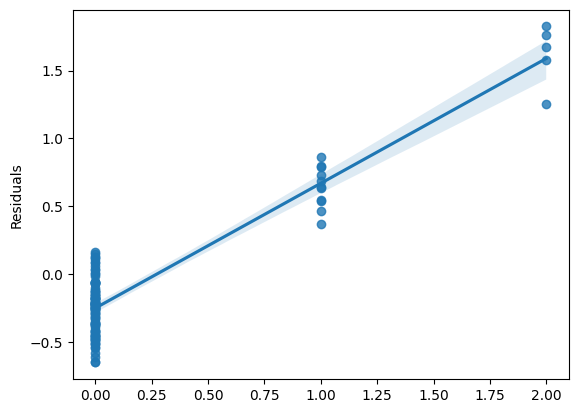

In [44]:
residuals = small_djs_Y_test - small_djs_Y_pred
ax = sns.regplot(x=small_djs_Y_test, y=residuals)
ax.set_xlabel('')
ax.set_ylabel('Residuals')
ax.set_title('')

<Axes: xlabel='coef', ylabel='name'>

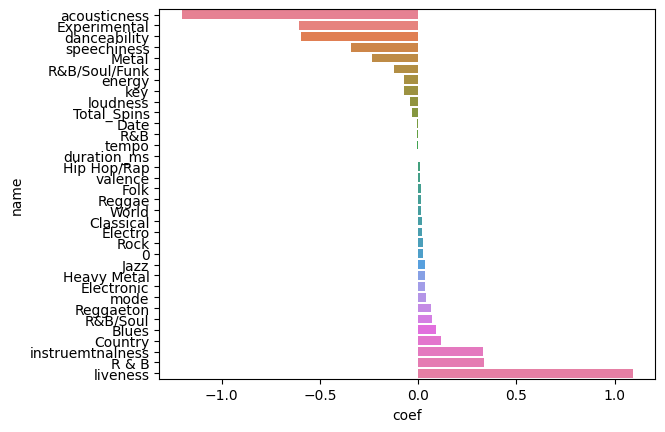

In [45]:
coeffs = (pd.DataFrame(zip(small_djs_X_train.columns, regr.coef_), columns=['name', 'coef'])).sort_values(by='coef', axis=0)
sns.barplot(x=coeffs['coef'], y=coeffs['name'], hue=coeffs['name'], data = coeffs)

In [46]:
regr_scaled = linear_model.LinearRegression(normalize=True)
regr_scaled.fit(small_djs_X_train, small_djs_Y_train)
pred_scaled = regr.predict(small_djs_X_test)
print("Coefficients: \n", regr_scaled.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, pred_scaled)}')
print(f'{regr_scaled.score(small_djs_X_test, small_djs_Y_test)}')

TypeError: LinearRegression.__init__() got an unexpected keyword argument 'normalize'

#### Improving the Model

In [47]:
lasso_mod = linear_model.Lasso()
lasso_mod.fit(small_djs_X_train, small_djs_Y_train)
lasso_pred = lasso_mod.predict(small_djs_X_test)
print("Coefficients: \n", lasso_mod.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, lasso_pred)}')
print(f'{lasso_mod.score(small_djs_X_test, small_djs_Y_test)}')

# add visualizations

Coefficients: 
 [-0.00000000e+00 -1.64273992e-03 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -9.02334433e-07]
Mean Squared Error: 0.2524522809991654
-0.04479096431987162


In [48]:
ridge_mod = linear_model.Ridge(alpha=1.0)
ridge_mod.fit(small_djs_X_train, small_djs_Y_train)
ridge_pred = ridge_mod.predict(small_djs_X_test)
print("Coefficients: \n", ridge_mod.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, ridge_pred)}')
print(f'{ridge_mod.score(small_djs_X_test, small_djs_Y_test)}')

# add visualizations

Coefficients: 
 [-3.84904390e-03 -1.94328133e-02  1.08094933e-02  8.04451737e-02
  7.55964389e-03  1.01549393e-01  1.22545359e-02  2.37778093e-02
 -2.99311933e-01 -3.04913620e-03  3.10735538e-02 -5.83243922e-03
  2.15076758e-02 -8.92160959e-02  1.55464457e-01 -1.20337251e-02
  5.43213948e-02 -1.28670256e-01  2.92649101e-03  3.85819727e-03
  1.25548142e-02  5.78139647e-04 -2.12000428e-01  3.40220555e-02
  3.40220555e-02 -1.19071571e-02 -2.87320369e-02 -8.10335066e-03
 -5.72989208e-01  2.01571953e-01  2.68653801e-01 -8.67873510e-02
 -3.43749868e-03  1.02291188e-06]
Mean Squared Error: 0.2471489578330012
-0.022842800084845516


In [ ]:
# permutation importance 

### Logistic Regression of Violation

In [61]:
small_djs['log_vol'] = None
small_djs['log_vol'].loc[small_djs['Violations'] >= 1] = 1
small_djs['log_vol'].loc[small_djs['Violations'] < 1] = 0
small_djs['log_vol'].astype(int)
small_djs

C:\Users\16107\AppData\Local\Temp\ipykernel_12616\3432037235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_djs['log_vol'].loc[small_djs['Violations'] >= 1] = 1
C:\Users\16107\AppData\Local\Temp\ipykernel_12616\3432037235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_djs['log_vol'].loc[small_djs['Violations'] < 1] = 0


,DJ Name,Date,New,Total_Spins,Time,0,Blues,Classical,Country,Electro,...,tempo,duration_ms,new_percent,new_violations,artist_bb,artist_violations,popular_violations,song_violations,Violations,log_vol
0,Adam Higgins,738890,7,22,12:06:25 AM,1.0,0.0,5.0,0.0,0.0,...,14.240864,45414.454545,0.318182,0,8.0,0.363636,1,0.0,1.0,1
1,Adam Higgins,738897,8,24,12:02:22 AM,1.0,0.0,8.0,0.0,0.0,...,15.140833,62700.000000,0.333333,0,2.0,0.083333,0,0.0,0.0,0
2,Adam Higgins,738904,8,25,12:03:00 AM,0.0,0.0,8.0,0.0,0.0,...,2.473560,5027.680000,0.320000,0,20.0,0.800000,1,0.0,1.0,1
3,Adam Higgins,738911,8,30,12:07:00 AM,4.0,0.0,8.0,0.0,0.0,...,12.686500,53041.366667,0.266667,0,2.0,0.066667,0,0.0,0.0,0
4,Adam Higgins,738918,8,24,12:07:00 AM,1.0,0.0,8.0,0.0,0.0,...,24.457917,68776.208333,0.333333,0,24.0,1.000000,1,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,otis cleveland,738901,0,21,10:16:13 PM,9.0,0.0,2.0,1.0,0.0,...,33.781762,55820.952381,0.000000,1,0.0,0.000000,0,0.0,0.0,0
554,otis cleveland,738908,0,20,8:00:21 PM,2.0,0.0,2.0,0.0,0.0,...,21.756650,52204.000000,0.000000,1,0.0,0.000000,0,0.0,0.0,0
555,otis cleveland,738915,0,40,8:00:33 PM,11.0,1.0,0.0,1.0,1.0,...,42.370225,57160.150000,0.000000,1,0.0,0.000000,0,0.0,0.0,0
556,otis cleveland,738922,0,18,8:01:38 PM,4.0,0.0,0.0,1.0,0.0,...,29.168389,55307.111111,0.000000,1,0.0,0.000000,0,0.0,0.0,0


In [62]:
train, test = train_test_split(small_djs, test_size = 0.2, train_size = 0.8)

X_train = train.drop(["DJ Name", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations", "log_vol"], axis=1)
X_test = test.drop(["DJ Name", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations", "log_vol"], axis=1)

Y_train = train["log_vol"].astype(int)
Y_test = test["log_vol"].astype(int)

log_mod = linear_model.LogisticRegression(max_iter=1000)
log_mod.fit(X_train, Y_train)
Y_pred = log_mod.predict(X_test)

ValueError: could not convert string to float: '10:03:45 AM'

#### Decision Tree? 

In [20]:
from sklearn import tree
violation_tree = tree.DecisionTreeClassifier()
violation_tree.fit(small_djs_X_train, small_djs_Y_train)

DecisionTreeClassifier()

In [22]:
from sklearn import ensemble
random_for = ensemble.RandomForestClassifier()
random_for.fit(small_djs_X_train, small_djs_Y_train)

RandomForestClassifier()

### DJ Clustering

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

#### Dimensionality Reduction

Variance with 6 components: 0.8420535510012399


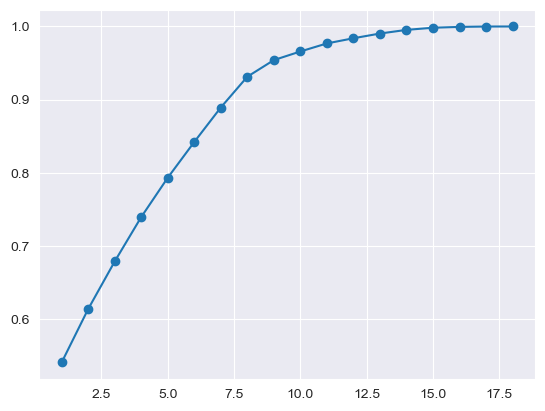

In [97]:
def determine_dimensionality(high_dim_df):
    """
    Plot the explained variance of the features with PCA
    to determine the dimensionality to be used.
    6 Components appears to be best, as it captures around
    80% of variability
    """

    high_dim_df = high_dim_df.drop(columns=["DJ Name"])

    # Apply standard scalar
    scalar = StandardScaler()
    x = scalar.fit_transform(X=high_dim_df)

    # PCA to find explained variances
    pca = PCA()
    pca.fit(x)

    # Visualize
    plt.plot(range(1, x.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), marker="o")
    print(f'Variance with 6 components: {pca.explained_variance_ratio_.cumsum()[5]}')

determine_dimensionality(djs_df)

DJ Name         Program Director
Total_Spins                93705
Avg_Start              81.161473
Avg_Duration           60.181847
Avg_Spins             132.726629
Blues                      518.0
Classical                  287.0
Country                    718.0
Electronic                6527.0
Experimental                 0.0
Folk                      1905.0
Heavy Metal                117.0
Hip Hop/Rap               1038.0
Jazz                     21512.0
R&B/Soul                  4890.0
Reggae                    2364.0
Rock                      5705.0
World                     2629.0
Violations                   696
Name: 176, dtype: object
DJ Name         Laima Harmon
Total_Spins             6090
Avg_Start         518.427807
Avg_Duration      174.935961
Avg_Spins          32.566845
Blues                    6.0
Classical             5327.0
Country                  1.0
Electronic              57.0
Experimental             0.0
Folk                    10.0
Heavy Metal              1.0


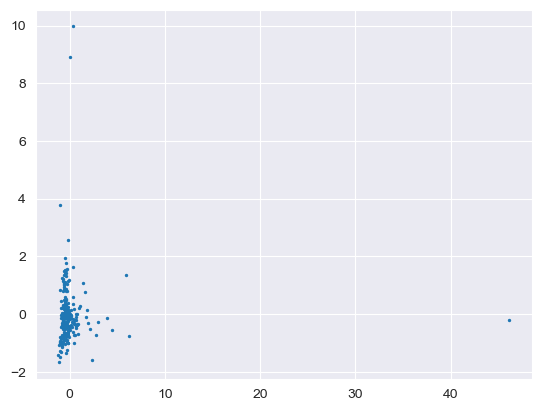

In [98]:
def dimension_reduction(high_dim_df: pd.DataFrame) -> np.ndarray:
    """
    Reduce dimensionality of the data to 2d for visualization and clustering
    """
    df_copy = high_dim_df
    #high_dim_df = high_dim_df[high_dim_df["DJ Name"] != "Program Director"]
    #high_dim_df = high_dim_df[high_dim_df["DJ Name"] != "JAH RED"]
    high_dim_df = high_dim_df.drop(columns=["DJ Name"])

    # Apply standard scalar
    scalar = StandardScaler()
    x = scalar.fit_transform(X=high_dim_df)

    # Apply PCA
    pca = PCA(n_components=6)
    x = pca.fit_transform(x)

    max_x_idx = np.argmax(x[:, 0])
    max_y_idx = np.argmax(x[:, 1])
    print(df_copy.iloc[max_x_idx, :])
    print(df_copy.iloc[max_y_idx, :])

    return x

def visualize(viz_data: np.ndarray):
    x = viz_data[:, 0]
    y = viz_data[:, 1]
    plt.scatter(x, y, s=2)

data = dimension_reduction(djs_df)
visualize(data)

#### Clustering Algorithm 1: DBSCAN

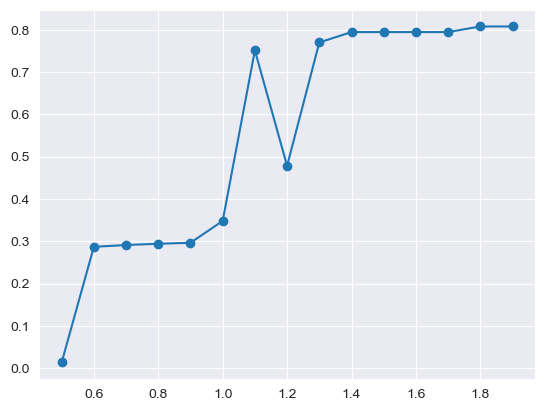

In [99]:
def dbscan_silhouette(x: np.ndarray):
    # Find the silhouette scores for different eps
    scores = []
    eps_range = np.arange(0.5, 2, 0.1)
    for eps in eps_range:
        db = DBSCAN(eps=eps, min_samples=2).fit(x)
        labels = db.labels_
        scores.append(silhouette_score(x, labels))

    # Visualize
    plt.plot(eps_range, scores, marker="o")

dbscan_silhouette(data)

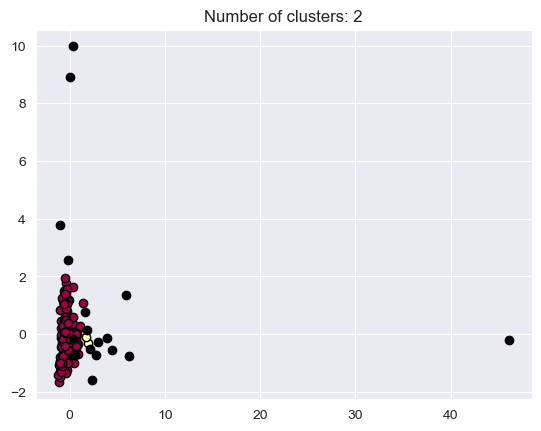

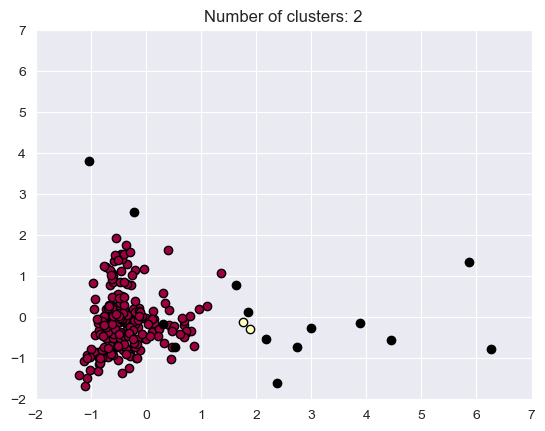

-1     17
 0    223
 1      2
dtype: int64

In [103]:
EPS = 1 # Chosen based on "bend" above

def dbscan_cluster(x: np.ndarray, eps=EPS):
    """
    Clustering using DBSCAN. DBSCAN is used because there are two obvious
    outliers. We hope that a density algorithm like DBSCAN can adjust for
    these outliers gracefully.
    """
    # Fit to clusters
    db = DBSCAN(eps=eps, min_samples=2)
    clusters = db.fit(x)
    labels = clusters.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Visualize
    def cluster_vis():
        """
        Function for visualizing the clusters
        Adapted from:
        https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
        """

        unique_labels = set(labels)
        core_samples_mask = np.zeros_like(labels, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True

        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = labels == k
            xy = x[class_member_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6,
            )

    plt.figure(0)
    cluster_vis()
    plt.title(f"Number of clusters: {n_clusters_}")
    plt.show()

    # Zoom in visualization, ignoring outliers
    plt.figure(1)
    cluster_vis()
    plt.axis([-2, 7, -2, 7])
    plt.title(f"Number of clusters: {n_clusters_}")
    plt.show()

    # Return cluster counts
    cluster_num, counts = np.unique(labels, return_counts=True)
    return pd.Series(data=counts, index=cluster_num)

cluster_counts = dbscan_cluster(data)
cluster_counts

#### Clustering Algorithm 2: Agglomerative

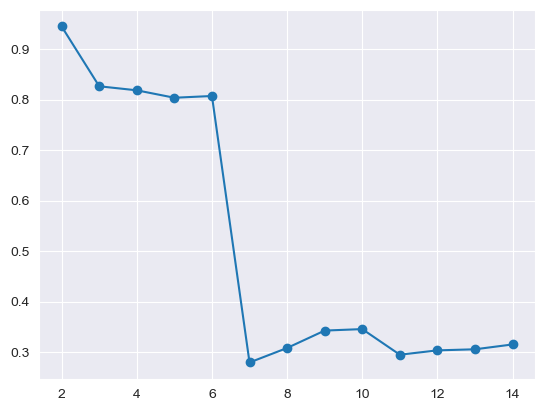

In [104]:
def agglom_silhouette(x: np.ndarray):
    # Find the silhouette scores for different eps
    scores = []
    n_range = range(2, 15)
    for n in n_range:
        agglom = AgglomerativeClustering(n_clusters=n).fit(x)
        labels = agglom.labels_
        scores.append(silhouette_score(x, labels))

    # Visualize
    plt.plot(n_range, scores, marker="o")

agglom_silhouette(data)

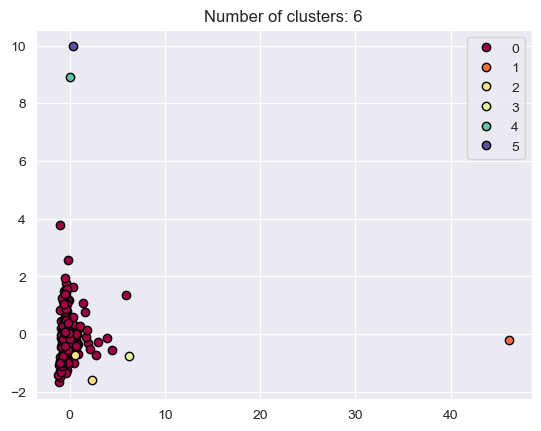

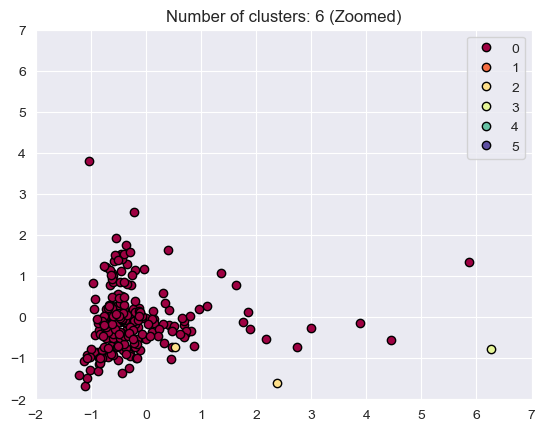

0    236
1      1
2      2
3      1
4      1
5      1
dtype: int64

In [108]:
N_CLUSTERS = 6 # Chosen based on silhouette analysis above

def agglom_cluster(x: np.ndarray, dj_names: np.ndarray, n_clusters: int = N_CLUSTERS):
    """
    Clustering using AgglomerativeClustering. An attempt to capture more
    data points than DBSCAN.
    """
    # Fit to clusters
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = agglom.fit(x)
    labels = clusters.labels_

    # Visualize
    def cluster_vis():
        """
        Function for visualizing the clusters
        Adapted from:
        https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
        """

        unique_labels = set(labels)

        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            class_member_mask = labels == k
            xy = x[class_member_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6,
                label=k
            )

    plt.figure(0)
    cluster_vis()
    plt.legend(loc="upper right")
    plt.title(f"Number of clusters: {n_clusters}")
    plt.show()

    # Zoom in visualization, ignoring outliers
    plt.figure(1)
    cluster_vis()
    plt.axis([-2, 7, -2, 7])
    plt.legend(loc="upper right")
    plt.title(f"Number of clusters: {n_clusters} (Zoomed)")
    plt.show()

    # Return cluster counts
    cluster_num, counts = np.unique(labels, return_counts=True)
    return labels, pd.Series(data=counts, index=cluster_num)


cluster_labels, cluster_counts = agglom_cluster(data, dj_names=djs_df["DJ Name"].unique())
cluster_counts

,Total_Spins,Avg_Start,Avg_Duration,Avg_Spins,Blues,Classical,Country,Electronic,Experimental,Folk,Heavy Metal,Hip Hop/Rap,Jazz,R&B/Soul,Reggae,Rock,World,Violations
label,,,,,,,,,,,,,,,,,,
0,-0.075169,0.016666,-0.014195,-0.059051,-0.052006,-0.071740,-0.053863,-0.068749,-0.064416,-0.060059,-0.095039,-0.029808,-0.065268,-0.064339,-0.077604,-0.055285,-0.090503,-0.077489
1,15.290562,-2.279216,-1.724442,12.343309,12.807467,0.751302,12.577579,14.951284,-0.064416,14.639317,1.309619,6.152748,15.389487,15.173480,9.298156,11.239694,10.351874,12.505715
2,0.306891,0.578133,0.504572,-0.222502,-0.046463,-0.023478,0.451025,0.075252,-0.064416,0.152939,10.645468,0.003657,0.048327,0.062113,-0.074454,1.580428,-0.058132,1.161945
3,1.008139,0.480751,0.656964,0.556974,-0.197390,-0.077465,-0.273884,-0.044313,-0.064416,-0.285805,-0.102113,1.105305,-0.052611,-0.093383,9.422031,-0.481315,11.323314,4.369623
4,0.015469,-2.505192,0.856666,0.397018,-0.172235,0.844684,-0.238086,1.237243,15.524175,-0.277970,0.045198,-0.115358,-0.042517,0.054259,-0.148380,-0.435956,-0.134088,-0.455921
5,0.811985,-0.785721,2.551661,1.083714,-0.071617,15.458991,-0.255985,-0.069851,-0.064416,-0.207458,-0.114389,-0.115358,0.012278,-0.074535,-0.108420,-0.435956,-0.066127,-0.455921


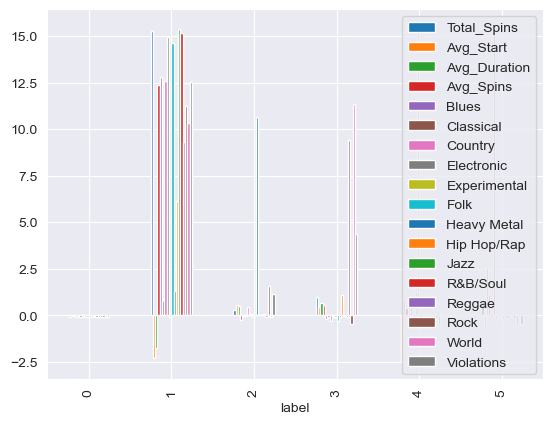

In [109]:
def interpret_clusters(dj_df: pd.DataFrame, labels: np.ndarray):
    """
    Create a visual representation to interpret which archetypes
    the clusters represent.

    WORK IN PROGRESS!!
    """
    # Apply a StandardScalar to the data
    #dj_df = dj_df[dj_df["DJ Name"] != "Program Director"]
    #dj_df = dj_df[dj_df["DJ Name"] != "JAH RED"]
    dj_df = dj_df.drop(columns=["DJ Name"])
    scalar = StandardScaler()
    x = scalar.fit_transform(dj_df)
    clustered_df = pd.DataFrame(x, columns=dj_df.columns)

    # Average the features across each label
    clustered_df["label"] = labels
    clustered_df = clustered_df.groupby("label").mean()

    # Plot the features with labels
    clustered_df.plot.bar()

    return clustered_df

df1 = interpret_clusters(djs_df, cluster_labels)
df1

## Hypothesis Testing

### Policy Violation Linear Regression

### DJ Clustering